In [1]:
# Importing the most important modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import seaborn as sns
import warnings
import pickle
import time
from tqdm.notebook import tqdm

# Import plotly modules to view time series in a more interactive way
import plotly.graph_objects as go
import plotly.offline as pyo
from matplotlib.pyplot import cm
from IPython.display import Image

# Importing time series split for cross validation of time series models
from sklearn.model_selection import TimeSeriesSplit

# For Data Mining
import os, glob
from pandas import read_csv

# For Data Cleaning
from datetime import datetime
#import missingno as msno

from matplotlib import pyplot
import matplotlib.dates as mdates

# Importing metrics to evaluate the implemented models
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Importing fbprophet for Prophet Model
from fbprophet import Prophet
# Prophet performance
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

# don't do this
warnings.filterwarnings('ignore')

In [2]:
# Setting the random seed for reproducability and several plotting style parameters
%matplotlib inline
plt.style.use('seaborn')
pyo.init_notebook_mode()
sns.set(rc={'figure.figsize':(14,8)})
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
RSEED = 42

## Time series

For the vaccination progress we have daily observations points as daily vaccinations or people vaccinated per country.  Our target is to predict how the vaccination progress will continue in the next weeks. Here we use Facebook Prophet for first prediction. Facebook Prophet is easy to implement and provide fast results but could have limitations here because normally it works best with a lot of historical data and strong seasonal effects. The procedure makes use of a decomposable time series model with three main model components: trend, seasonality and holidays.

In [113]:
#import cleaned data set:
df_daily = pd.read_csv('df2.csv', index_col=None)
#change date to datetime
df_daily['date'] = pd.to_datetime(df_daily['date'])
df_daily.head()

country iso_code       date  total_vaccinations  people_vaccinated  \
0  Afghanistan      AFG 2021-02-23                 NaN                NaN   
1  Afghanistan      AFG 2021-02-24                 NaN                NaN   
2  Afghanistan      AFG 2021-02-25                 NaN                NaN   
3  Afghanistan      AFG 2021-02-26                 NaN                NaN   
4  Afghanistan      AFG 2021-02-27                 NaN                NaN   

   people_fully_vaccinated  daily_vaccinations  \
0                      0.0              1367.0   
1                      0.0              1367.0   
2                      0.0              1367.0   
3                      0.0              1367.0   
4                      0.0              1367.0   

   total_vaccinations_per_hundred  people_vaccinated_per_hundred  \
0                             NaN                            NaN   
1                             NaN                            NaN   
2                             NaN                            NaN   
3                             NaN                            NaN   
4                             NaN                            NaN   

   people_fully_vaccinated_per_hundred  daily_vaccinations_per_million  \
0                                  0.0                            35.0   
1                                  0.0                            35.0   
2                                  0.0                            35.0   
3                                  0.0                            35.0   
4                                  0.0                            35.0   

             vaccines  
0  Oxford/AstraZeneca  
1  Oxford/AstraZeneca  
2  Oxford/AstraZeneca  
3  Oxford/AstraZeneca  
4  Oxford/AstraZeneca

In [4]:
#split date into day, month, year and weekday_name:
df_daily.date.dt.to_period('D').dt.to_timestamp()
df_daily.date.dt.to_period('M').dt.to_timestamp()
df_daily.date.dt.to_period('Y').dt.to_timestamp()


df_daily['day'] = df_daily['date'].dt.day
df_daily['month'] = df_daily['date'].dt.month
df_daily['year'] = df_daily['date'].dt.year
df_daily['weekday_name'] = df_daily['date'].dt.day_name()#day_of_week  
# Display a random sampling of 5 rows
df_daily.sample(5, random_state=0)

country iso_code       date  total_vaccinations  people_vaccinated  \
4512   Mauritius      MUS 2021-02-02                 NaN                NaN   
2412     Finland      FIN 2021-02-09            227427.0           173558.0   
4732    Mongolia      MNG 2021-03-11             48265.0                NaN   
4245  Luxembourg      LUX 2021-01-08                 NaN                NaN   
5700       Qatar      QAT 2021-03-11                 NaN                NaN   

      people_fully_vaccinated  daily_vaccinations  \
4512                      0.0                58.0   
2412                  53869.0              9065.0   
4732                      0.0              5009.0   
4245                      0.0                62.0   
5700                      0.0             15381.0   

      total_vaccinations_per_hundred  people_vaccinated_per_hundred  \
4512                             NaN                            NaN   
2412                            4.10                           3.13   
4732                            1.47                            NaN   
4245                             NaN                            NaN   
5700                             NaN                            NaN   

      people_fully_vaccinated_per_hundred  daily_vaccinations_per_million  \
4512                                 0.00                            46.0   
2412                                 0.97                          1636.0   
4732                                 0.00                          1528.0   
4245                                 0.00                            99.0   
5700                                 0.00                          5339.0   

                                          vaccines  day  month  year  \
4512                            Oxford/AstraZeneca    2      2  2021   
2412  Moderna, Oxford/AstraZeneca, Pfizer/BioNTech    9      2  2021   
4732                            Oxford/AstraZeneca   11      3  2021   
4245  Moderna, Oxford/AstraZeneca, Pfizer/BioNTech    8      1  2021   
5700                               Pfizer/BioNTech   11      3  2021   

     weekday_name  
4512      Tuesday  
2412      Tuesday  
4732     Thursday  
4245       Friday  
5700     Thursday

In [5]:
# Define plotting parameters and custom color palette 
cmaps_hex = ['#193251','#FF5A36','#1E4485', '#99D04A','#FF5A36', '#DB6668']
#sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

In [6]:
#select required columns:
df_time = df_daily.copy()
df_time.set_index('date')
df_time = df_time[['date','country', 'daily_vaccinations', 'people_fully_vaccinated_per_hundred']]
df_time.sample(5)

date      country  daily_vaccinations  \
6586 2021-03-03  South Korea             25737.0   
4290 2021-02-22   Luxembourg              1129.0   
4880 2021-01-28        Nepal             18862.0   
3848 2021-03-11       Jordan              3008.0   
5221 2021-02-18         Oman              2116.0   

      people_fully_vaccinated_per_hundred  
6586                                 0.00  
4290                                 1.32  
4880                                 0.00  
3848                                 0.00  
5221                                 0.37

In [7]:
#check for missing values
missing_values = pd.DataFrame(df_time.isnull().sum(), columns=['ID'])
missing_values

ID
date                                  0
country                               0
daily_vaccinations                    6
people_fully_vaccinated_per_hundred   0

We have 6 missing values for daily_vaccinations, which has to be further investigated  as all values were filled during cleaning activities but for now we just drop the 6 missing values.

In [8]:
df_time.dropna(axis=0)

date      country  daily_vaccinations  \
0    2021-02-23  Afghanistan              1367.0   
1    2021-02-24  Afghanistan              1367.0   
2    2021-02-25  Afghanistan              1367.0   
3    2021-02-26  Afghanistan              1367.0   
4    2021-02-27  Afghanistan              1367.0   
...         ...          ...                 ...   
7492 2021-03-20     Zimbabwe               836.0   
7493 2021-03-21     Zimbabwe               910.0   
7494 2021-03-22     Zimbabwe               805.0   
7495 2021-03-23     Zimbabwe               655.0   
7496 2021-03-24     Zimbabwe              1400.0   

      people_fully_vaccinated_per_hundred  
0                                     0.0  
1                                     0.0  
2                                     0.0  
3                                     0.0  
4                                     0.0  
...                                   ...  
7492                                  0.0  
7493                                  0.0  
7494                                  0.0  
7495                                  0.0  
7496                                  0.0  

[7491 rows x 4 columns]

In [9]:
df_time.isnull().any()

date                                   False
country                                False
daily_vaccinations                      True
people_fully_vaccinated_per_hundred    False
dtype: bool

In [10]:
df_time.dropna(inplace = True)

In [11]:
#check for missing values in %
round(100*(df_time.isnull().sum()/len(df_time.index)),0)

date                                   0.0
country                                0.0
daily_vaccinations                     0.0
people_fully_vaccinated_per_hundred    0.0
dtype: float64

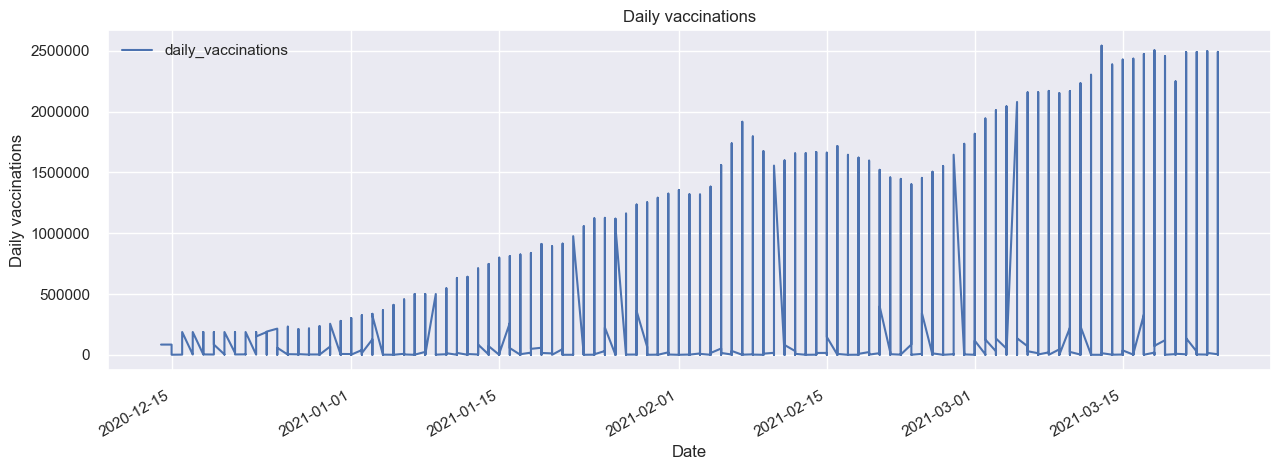

In [27]:
# plot the time series for daily vaccinations:
df_time1= df_time[['date','daily_vaccinations']]
df_time1.set_index('date', inplace=True)
ax1 = df_time1.plot()
# Add title and axis names

ax1.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.title('Daily vaccinations')
plt.xlabel('Date')
plt.ylabel('Daily vaccinations')

pyplot.show()

Fortunately we already see an increase in daily vaccinations. 

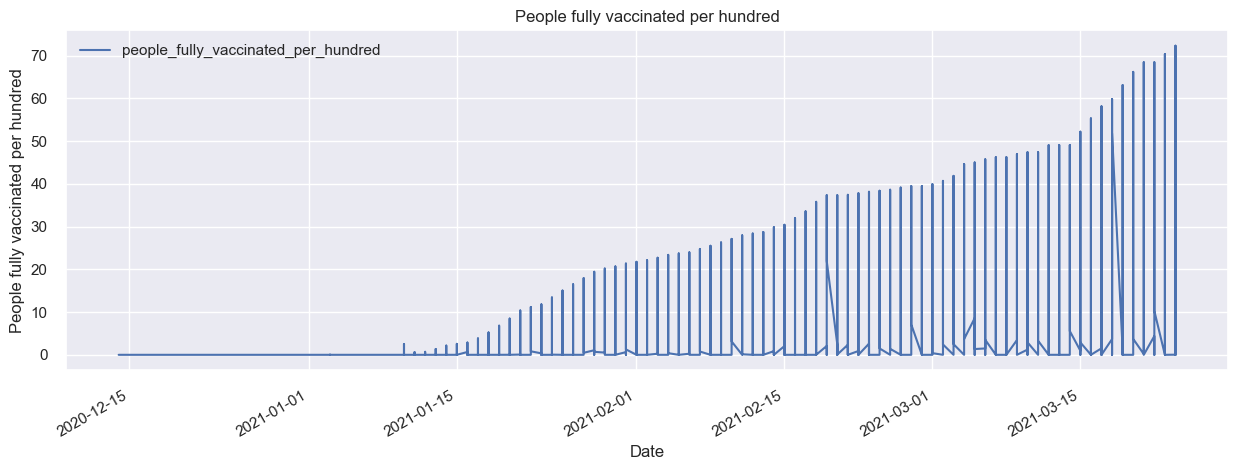

In [385]:
# plot the time series for daily vaccinations:
df_time_p= df_time[['date','people_fully_vaccinated_per_hundred']]
df_time_p.set_index('date', inplace=True)
ax1 = df_time_p.plot()
# Add title and axis names

ax1.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.title('People fully vaccinated per hundred')
plt.xlabel('Date')
plt.ylabel('People fully vaccinated per hundred')

pyplot.show()

The most crucial question in the fight against Covid-19 is when we will reach 70% or more vaccinated people to have a herd immunisation. It is questionable whether we will achieve this goal worldwide in the near future, as vaccines are not yet available in sufficient quantities and, at the moment, the wealthy countries in particular are dividing the vaccines among themselves.

In [78]:
# sum up all vaccinations values per day for getting a global value
df_time_index = df_time[['date', 'daily_vaccinations']]#
df_time_index['date'] = pd.to_datetime(df_time_index.date)

df_time_index.set_index('date', inplace=True)
df_time_index.index.get_level_values('date').floor('D')
df_time_index = df_time_index.groupby('date').sum().reset_index()
df_time_index.to_csv('dates_aggregated.csv', encoding='utf-8', index=True)

## Prediction of global vaccination progress:

In order to run our FB model we have to rename ‘date’ column as ‘ds’ and ‘passenger’ column as ‘y’.This renaming is mandatory.
First we split our data into a train and test data set to start running our model:

In [110]:
#prediction of daily vaccinations globally:
df_time1= df_time[['date','daily_vaccinations']]
df_time1.set_index('date', inplace=True)
df_time1

daily_vaccinations
date                          
2021-02-23              1367.0
2021-02-24              1367.0
2021-02-25              1367.0
2021-02-26              1367.0
2021-02-27              1367.0
...                        ...
2021-03-20               836.0
2021-03-21               910.0
2021-03-22               805.0
2021-03-23               655.0
2021-03-24              1400.0

[7491 rows x 1 columns]

In [118]:
#train - test - split
df_time_d = df_time1.copy()
df_time_d.reset_index(inplace=True)
df_time_d['cap']= 7790000000
df_time_d.columns=['ds','y', 'cap']

train_test_split_ratio = int(len(df_time_d)*0.8)
train_data, test_data = df_time_d[:train_test_split_ratio], df_time_d[train_test_split_ratio:]

train_data.sample(15)

ds         y         cap
4318 2021-02-13     260.0  7790000000
5662 2021-02-07    4286.0  7790000000
1500 2020-12-31  187500.0  7790000000
5242 2021-03-17    1668.0  7790000000
3035 2021-01-06    3959.0  7790000000
4480 2021-03-05    2378.0  7790000000
4922 2021-03-17   44361.0  7790000000
4342 2021-03-09     974.0  7790000000
4162 2021-01-15    3820.0  7790000000
4364 2021-03-24    7031.0  7790000000
5613 2021-03-22   26186.0  7790000000
1592 2021-02-27   11557.0  7790000000
3772 2021-03-04     740.0  7790000000
4150 2021-01-03    1047.0  7790000000
1475 2021-03-15  292901.0  7790000000

In [119]:
# prepare expected column names
#train_data.columns = ['ds', 'y', 'cap']
#train_data['ds']= pd.to_datetime(train_data['ds'])
# define the model
model = Prophet(growth = 'logistic', weekly_seasonality = True)
# fit the model
model.fit(train_data)
print(train_data.tail())

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds      y         cap
5987 2021-03-14  314.0  7790000000
5988 2021-03-15  314.0  7790000000
5989 2021-03-16  314.0  7790000000
5990 2021-03-17  301.0  7790000000
5991 2021-03-18  289.0  7790000000


In [122]:
#making daily predictions for one year:
future = model.make_future_dataframe(periods=7*20, freq='D')
future['cap']= 7790000000
future.tail()

ds         cap
235 2021-08-07  7790000000
236 2021-08-08  7790000000
237 2021-08-09  7790000000
238 2021-08-10  7790000000
239 2021-08-11  7790000000

In [123]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds         yhat     yhat_lower     yhat_upper
235 2021-08-07  -591.259218 -205404.315143  210450.599021
236 2021-08-08    36.090047 -202971.734272  217848.844434
237 2021-08-09  1873.987182 -202320.969316  205690.414731
238 2021-08-10  2904.512689 -192665.062453  211360.566653
239 2021-08-11   687.141002 -201821.692456  213566.350894


yhat: the forecasted value of our metric

yhat_lower: the lower bound of our forecasts

yhat_upper: the upper bound of our forecasts

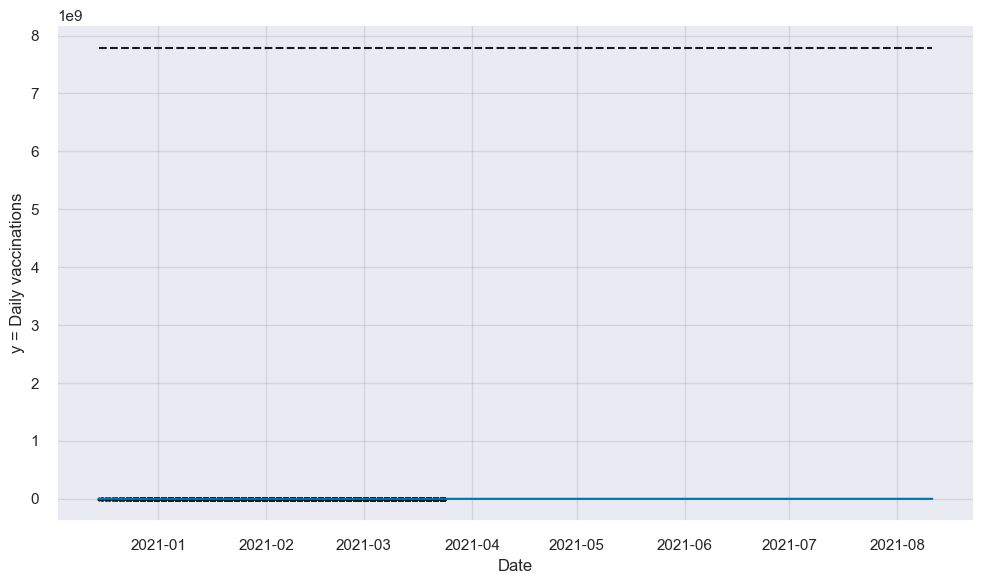

In [127]:
fig1 = model.plot(forecast, xlabel='Date',
    ylabel='y = Daily vaccinations')#uncertainty=True,

Prophet plots the observed values of time series(black dots),the forecasted values(blue lines) and the uncertainty intervals of our forecasts(blue shaded region)

<AxesSubplot:xlabel='ds'>

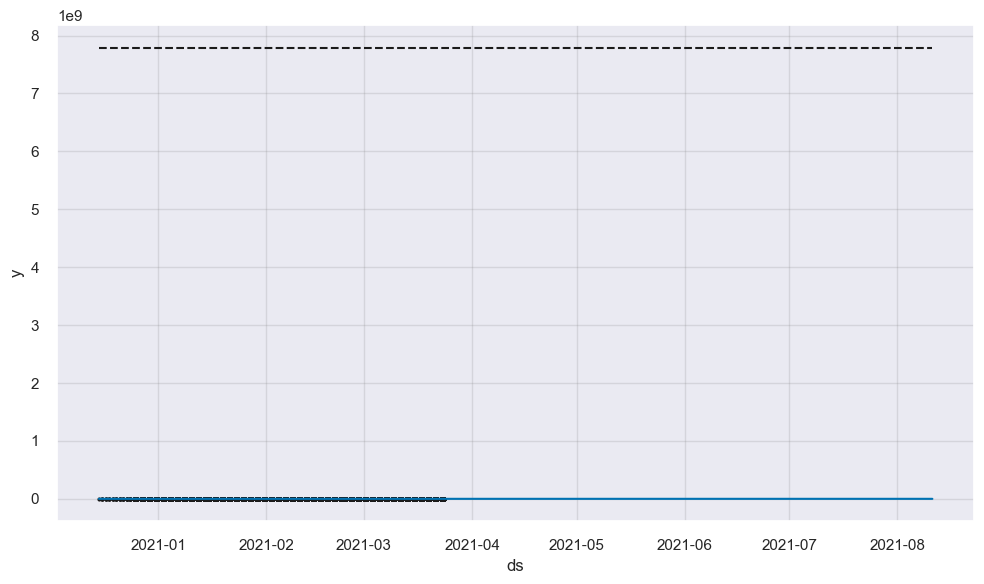

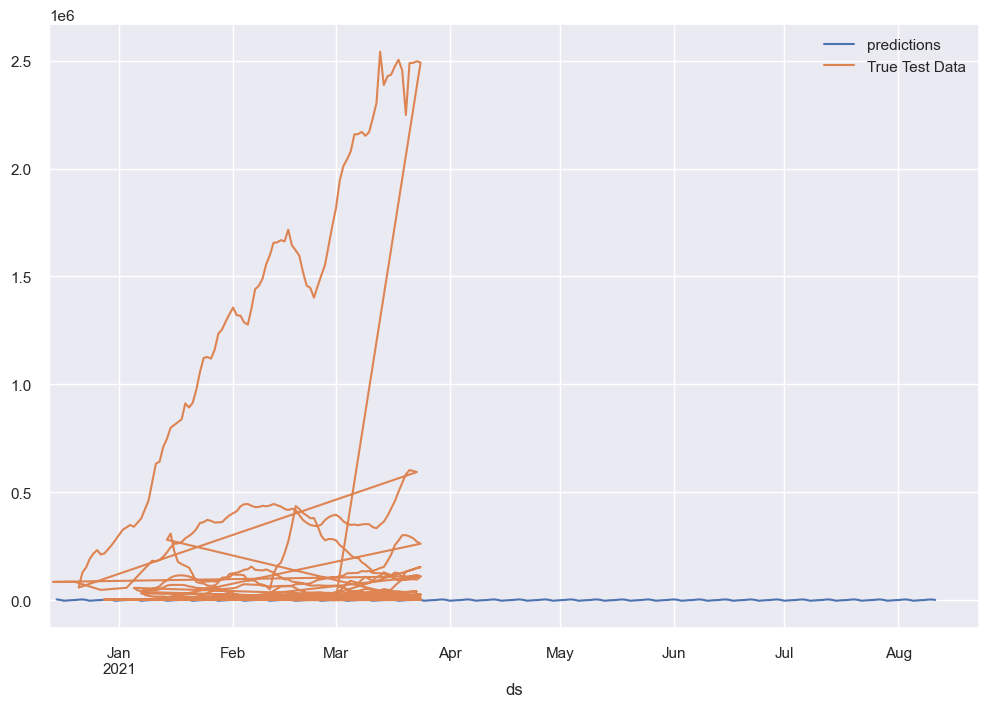

In [130]:
model.plot(forecast)
ax=forecast.plot(x='ds',y='yhat',legend=True,label='predictions',figsize=(12,8))
test_data.plot(x='ds',y='y',legend=True,label='True Test Data',ax=ax,xlim=('2020-12-13','2021-08-23'))

One other feature of Prophet is its ability to return components of our forecasts.This can help reveal how daily, weekly and yearly patterns of the time series contribute to the overall forecasted values:

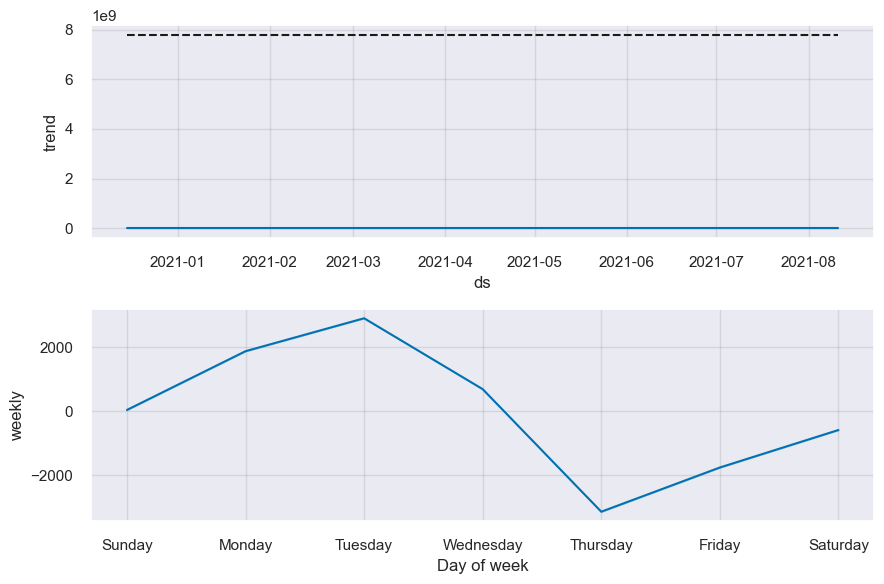

In [131]:
fig2 = model.plot_components(forecast)

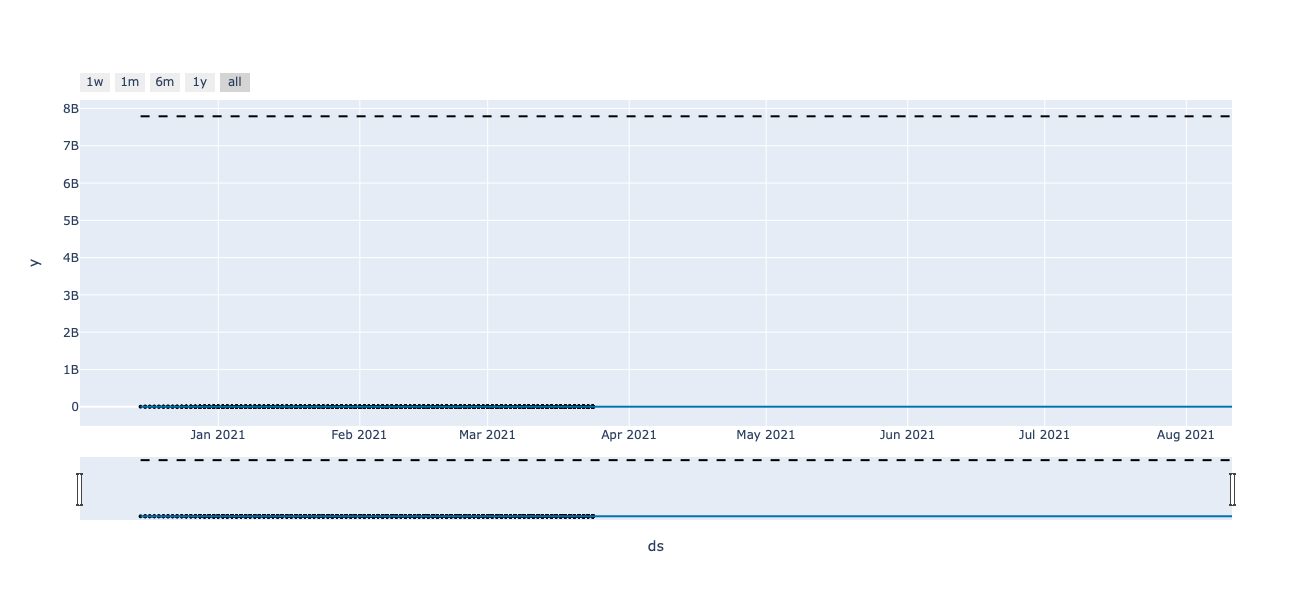

In [132]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)

## Performance Metrics:

In [133]:

# Initial training period.
initial= 7*8
initial=str(initial)+' days'
#Period length that we perform the cross validation for.
period= 7
period=str(period)+' days'
#Horizon of prediction essentially for each fold.
horizon = 20
horizon=str(horizon)+' days'
fb_cv=cross_validation(model,initial=initial,period=period,
horizon=horizon)
# Performance Metrics of fb_cv
performance_metrics(fb_cv)

INFO:fbprophet:Making 4 forecasts with cutoffs between 2021-02-11 00:00:00 and 2021-03-04 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

horizon           mse           rmse           mae      mape     mdape  \
0   3 days  1.383790e+10  117634.585693  39903.844857  4.793725  1.418508   
1   4 days  1.382489e+10  117579.271898  39143.500631  3.190343  1.171405   
2   5 days  1.418125e+10  119085.041120  38388.662926  1.916313  1.006854   
3   6 days  1.452684e+10  120527.328443  38218.637793  3.255106  0.953348   
4   7 days  1.463947e+10  120993.679650  38605.510586  5.317312  0.958857   
5   8 days  1.539470e+10  124075.400394  41423.678574  6.239199  1.246487   
6   9 days  1.678234e+10  129546.666025  43964.831587  5.433786  1.461053   
7  10 days  1.740796e+10  131939.246941  44033.208172  4.005304  1.329104   
8  11 days  1.893928e+10  137620.066596  44109.309894  2.665262  1.132185   
9  12 days  2.147363e+10  146538.828975  44669.340207  1.633182  1.003231   
10 13 days  2.379851e+10  154267.648264  45652.051089  2.644280  0.947698   
11 14 days  2.629609e+10  162160.706498  46792.881652  4.276696  0.946572   
12 15 days  2.956608e+10  171947.904178  50509.021434  5.142616  1.161450   
13 16 days  3.348324e+10  182984.260170  54252.282419  4.543530  1.348424   
14 17 days  3.720054e+10  192874.422488  55530.233424  3.383137  1.231058   
15 18 days  4.191626e+10  204734.604121  57363.858640  2.272244  1.101314   
16 19 days  4.739260e+10  217698.408660  59677.972140  1.492008  1.003878   
17 20 days  4.639296e+10  215390.245854  58471.325882  2.361997  0.953100   

    coverage  
0   0.939844  
1   0.940307  
2   0.939981  
3   0.940783  
4   0.941256  
5   0.940217  
6   0.932296  
7   0.925729  
8   0.929043  
9   0.933378  
10  0.934466  
11  0.934294  
12  0.929967  
13  0.923868  
14  0.920160  
15  0.914210  
16  0.908802  
17  0.911724

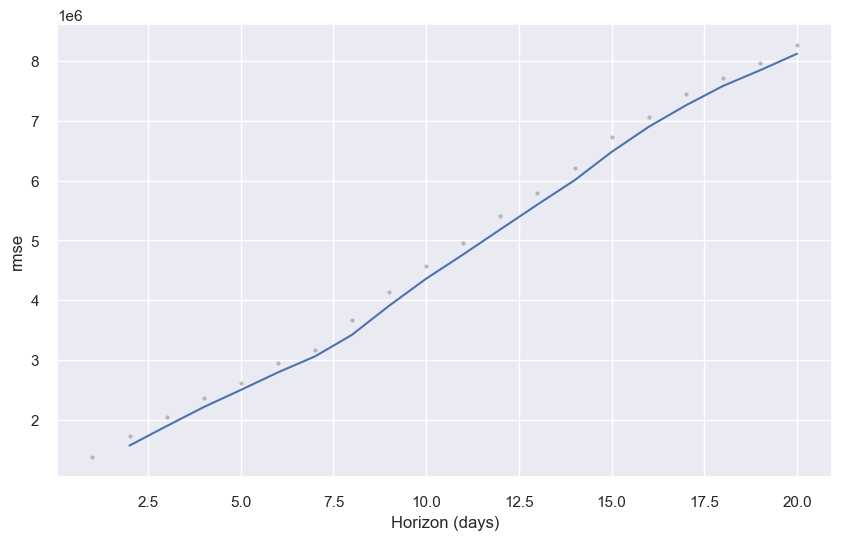

In [339]:
plot_cross_validation_metric(fb_cv,'rmse');

## Parallelizing Cross Validation with Dask

In [134]:
from distributed import Client
from fbprophet.diagnostics import cross_validation

client = Client()
client

<Client: 'tcp://127.0.0.1:57091' processes=4 threads=8, memory=8.00 GiB>

In [135]:

df_cv = cross_validation(model, 
                         horizon="10 days",
                         period="20 days", 
                         initial="60 days", 
                         parallel="dask"
                        )

INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-02-22 00:00:00 and 2021-03-14 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:57091' processes=4 threads=8, memory=8.00 GiB>


In [136]:
from fbprophet.diagnostics import performance_metrics

performance_metrics(df_cv, rolling_window=1)

horizon           mse           rmse           mae      mape     mdape  \
0 10 days  4.336237e+10  208236.332317  56548.542134  3.153863  1.063738   

   coverage  
0  0.926843

## Hyperparameter Optimization with Dask

In [137]:
import itertools

param_grid = {'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
              'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
              'seasonality_mode': ['additive', 'multiplicative']}

# generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # store the RMSEs for each params here

In [138]:
# go through all parameter combos
for i in range(len(all_params)):
  
    # create & fit model with given params combo
    model = Prophet(daily_seasonality=False, **all_params[i]).fit(train_data)
    
    # cross validate the model 
    df_cv = cross_validation(model, 
                             horizon="60 days",
                             period="182.5 days", 
                             initial="10 days", 
                             parallel="dask")
    
    df_p = performance_metrics(df_cv, rolling_window=1)
    # pull rmse and add it to the list
    rmses.append(df_p['rmse'].values[0])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2021-01-23 00:00:00 and 2021-01-23 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:57091' processes=4 threads=8, memory=8.00 GiB>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2021-01-23 00:00:00 and 2021-01-23 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:57091' processes=4 threads=8, memory=8.00 GiB>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2021-01-23 00:00:00 and 2021-01-23 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:57091' processes=4 threads=8, memory=8.00 GiB>
INFO:fbprophet:Disabling yearly seasonality. Run 

In [139]:
df_p

horizon           mse           rmse           mae        mape      mdape  \
0 60 days  2.919480e+10  170864.851763  92503.406704  170.133072  16.478364   

   coverage  
0  0.952646

### Let's take a closer look by some country data, starting with te data for the United States:

In [140]:
#limiting dataset to United States only:
df_time_us = df_time[df_time.country == 'United States']
df_time_us.tail()

date        country  daily_vaccinations  \
7402 2021-03-20  United States           2248285.0   
7403 2021-03-21  United States           2488734.0   
7404 2021-03-22  United States           2489697.0   
7405 2021-03-23  United States           2497025.0   
7406 2021-03-24  United States           2490889.0   

      people_fully_vaccinated_per_hundred  
7402                                12.87  
7403                                13.20  
7404                                13.43  
7405                                13.61  
7406                                13.86

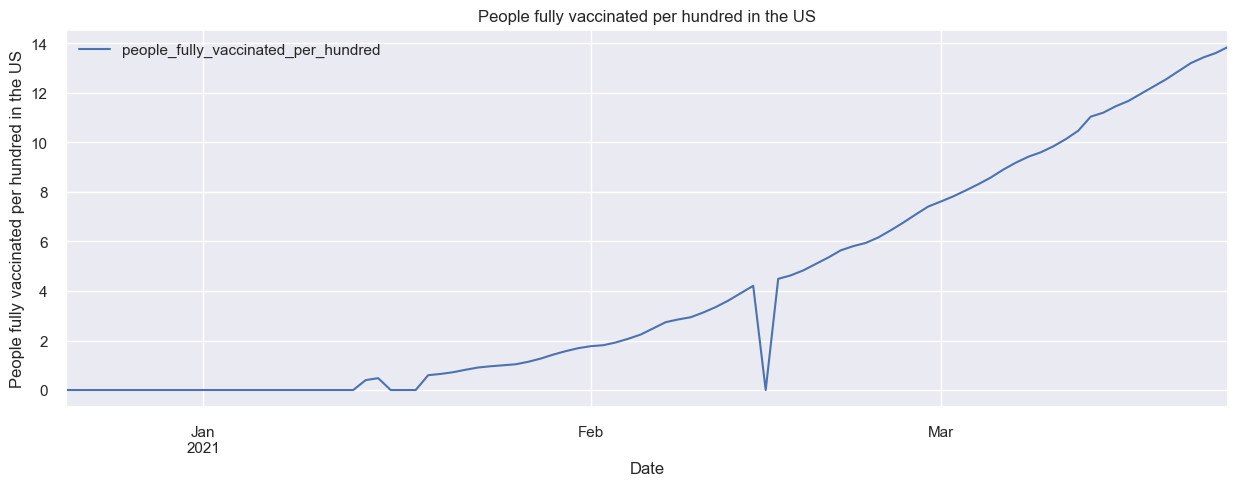

In [141]:
# plot the time series for daily vaccinations:
df_time_us= df_time_us[['date','people_fully_vaccinated_per_hundred']]
df_time_us.set_index('date', inplace=True)
ax1 = df_time_us.plot()
# Add title and axis names

ax1.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.title('People fully vaccinated per hundred in the US')
plt.xlabel('Date')
plt.ylabel('People fully vaccinated per hundred in the US')

pyplot.show()

In [146]:
df_time_us.reset_index(inplace=True)
df_time_m_us1 = df_time_us[['date','people_fully_vaccinated_per_hundred']]#,'daily_vaccinations', 
#train - test - split

df_time_m_us2 = df_time_m_us1
#adding US population:
df_time_m_us2['cap']= 328000000
train_test_split_ratio = int(len(df_time_m_us2)*0.8)
train_data, test_data = df_time_m_us2[:train_test_split_ratio], df_time_m_us2[train_test_split_ratio:]



In [147]:
df_time_m_us2.tail()

date  people_fully_vaccinated_per_hundred        cap
89 2021-03-20                                12.87  328000000
90 2021-03-21                                13.20  328000000
91 2021-03-22                                13.43  328000000
92 2021-03-23                                13.61  328000000
93 2021-03-24                                13.86  328000000

In [148]:
# prepare expected column names
train_data.columns = ['ds', 'y', 'cap']
train_data['ds']= pd.to_datetime(train_data['ds'])
# define the model
model = Prophet(growth = 'logistic')
# fit the model
model.fit(train_data)
print(train_data.tail())

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           ds     y        cap
70 2021-03-01  7.61  328000000
71 2021-03-02  7.82  328000000
72 2021-03-03  8.06  328000000
73 2021-03-04  8.31  328000000
74 2021-03-05  8.58  328000000


In [149]:
future = model.make_future_dataframe(periods=71)
future['cap']= 3280000
future.tail()

ds      cap
141 2021-05-11  3280000
142 2021-05-12  3280000
143 2021-05-13  3280000
144 2021-05-14  3280000
145 2021-05-15  3280000

In [150]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
141 2021-05-11  2.259082   -1.758530    5.708584
142 2021-05-12  1.089708   -2.588630    4.787246
143 2021-05-13 -2.731932   -6.496798    1.376694
144 2021-05-14  0.548592   -3.440023    4.304424
145 2021-05-15 -3.040425   -6.839668    0.656277

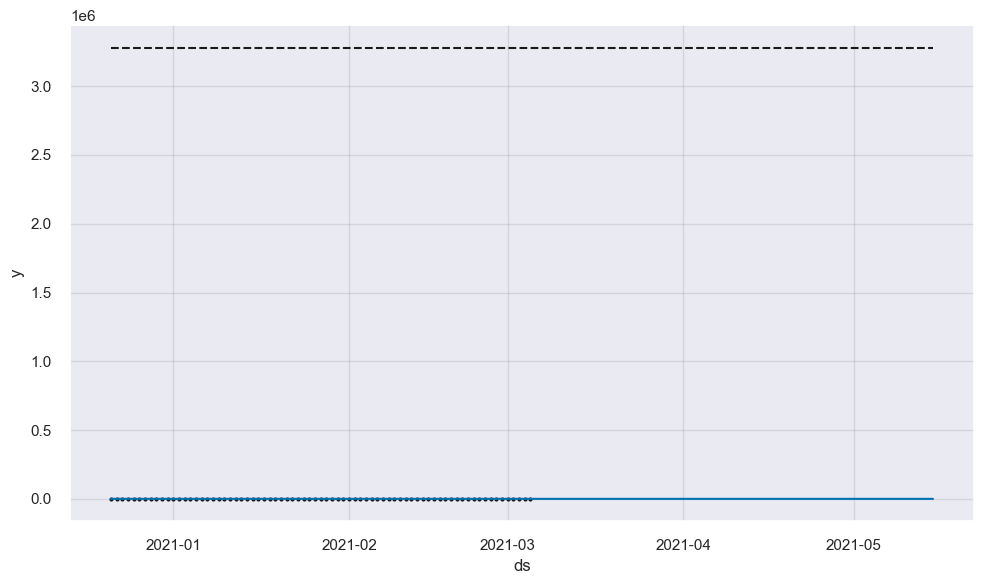

In [151]:
fig1 = model.plot(forecast)

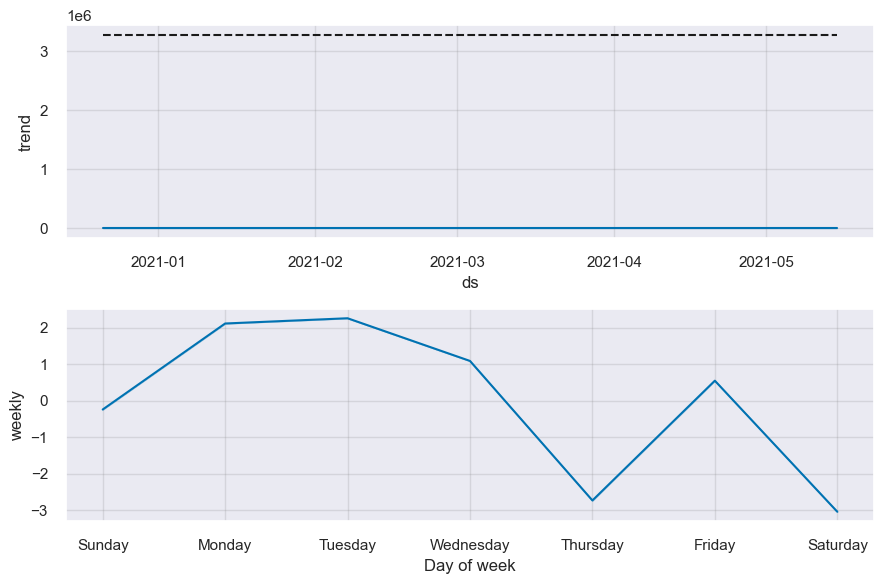

In [152]:
fig2 = model.plot_components(forecast)

In [153]:
#!install jupyterlab-plotly@4.14.3
#%jupyter labextension install jupyterlab-plotly@4.14.3

In [154]:
#%jupyter labextension install @jupyter-widgets/jupyterlab-manager plotlywidget@4.14.3

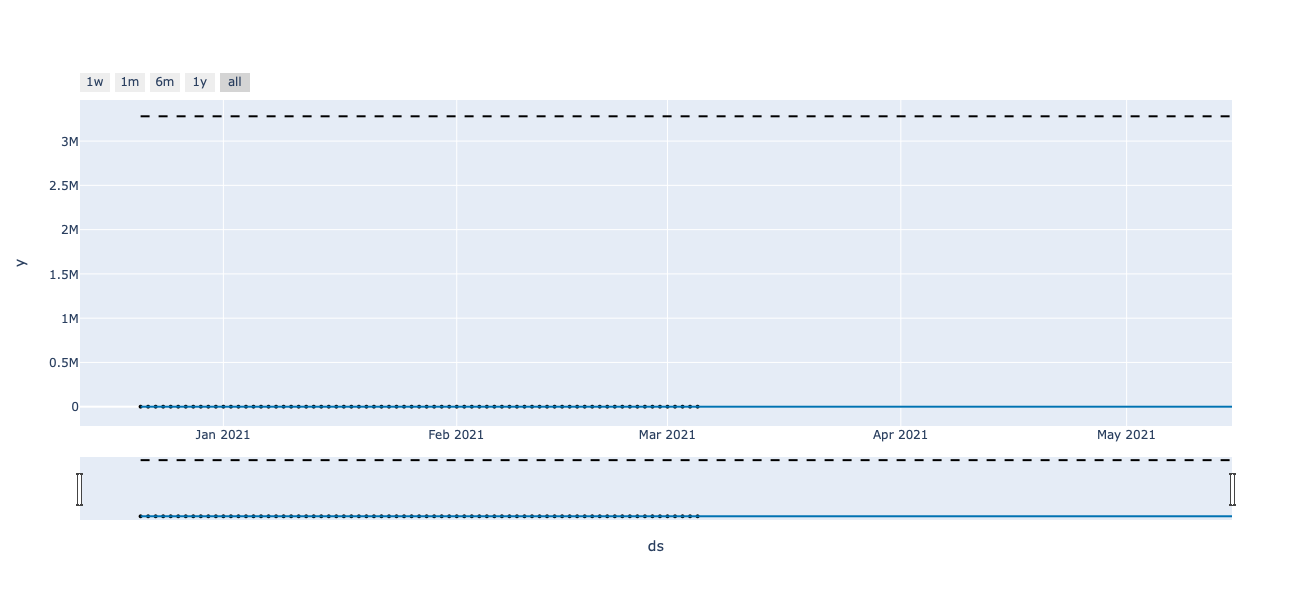

In [155]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)

## Prediction for Germany

In [157]:
df_time_m_ger = df_time[df_time.country == 'Germany']
df_time_m_ger1 = df_time_m_ger[['date','daily_vaccinations']]
#train - test - split
df_time_m_ger2 = df_time_m_ger1
train_test_split_ratio = int(len(df_time_m_ger2)*0.8)
train_data, test_data = df_time_m_ger2[:train_test_split_ratio], df_time_m_ger2[train_test_split_ratio:]



In [158]:
# prepare expected column names
train_data.columns = ['ds', 'y']
train_data['ds']= pd.to_datetime(train_data['ds'])
# define the model
model = Prophet()
# fit the model
model.fit(train_data)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [159]:
future = model.make_future_dataframe(periods=365)
future['cap']= 80000000
future.tail()

ds       cap
428 2022-03-01  80000000
429 2022-03-02  80000000
430 2022-03-03  80000000
431 2022-03-04  80000000
432 2022-03-05  80000000

In [160]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat    yhat_lower    yhat_upper
428 2022-03-01  1.623271e+06  9.988762e+05  2.292613e+06
429 2022-03-02  1.628458e+06  1.001744e+06  2.299024e+06
430 2022-03-03  1.632966e+06  1.008783e+06  2.307281e+06
431 2022-03-04  1.637568e+06  1.005829e+06  2.316417e+06
432 2022-03-05  1.639399e+06  1.004337e+06  2.322709e+06

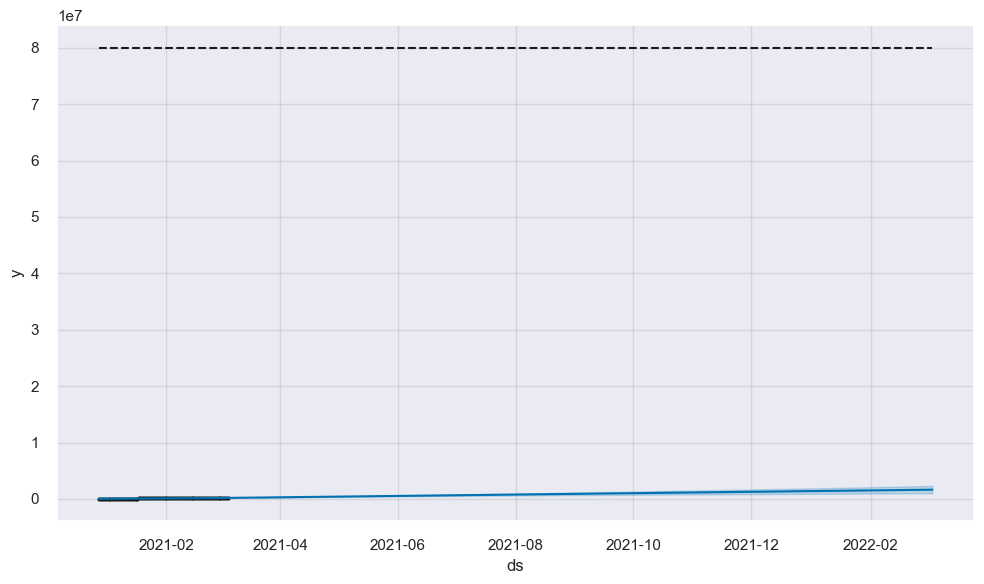

In [161]:
fig1 = model.plot(forecast)

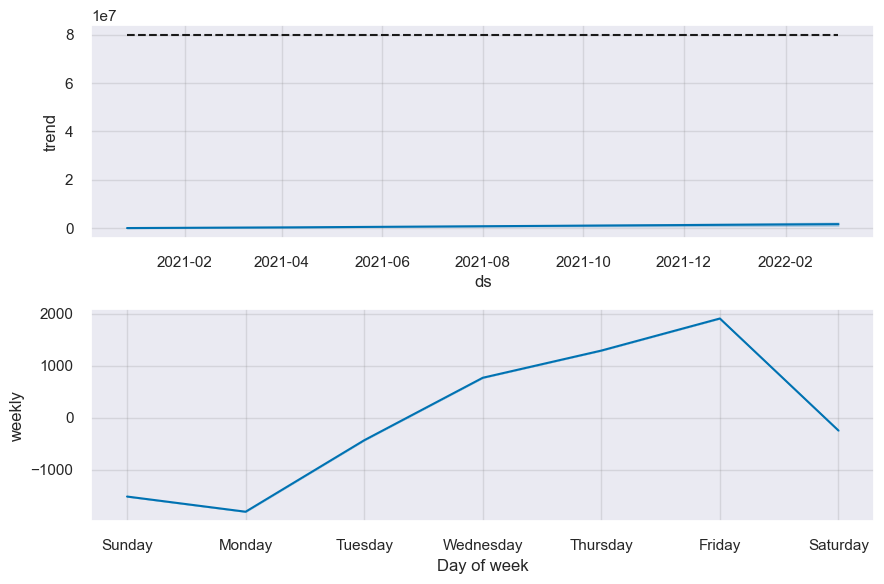

In [162]:
fig2 = model.plot_components(forecast)

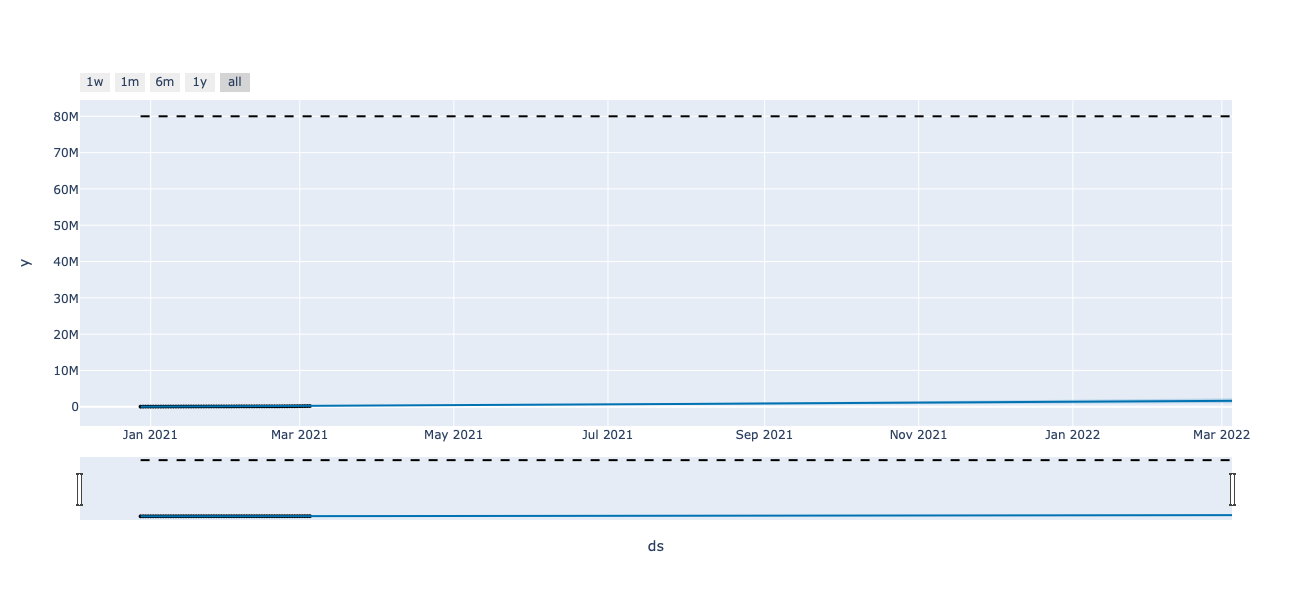

In [163]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)

In [164]:
#for other countries:

In [167]:
top_10_vacc = list(df_time[(~df_time['people_fully_vaccinated_per_hundred'].isna())&(df_time['date']=='2021-03-28')].sort_values(by='people_fully_vaccinated_per_hundred',ascending=False).head(10)['country'])

In [168]:
top_10_vacc

[]

In [169]:
#Top 10 GDP countries in the world vaccination rates
graph = sns.lineplot(data=df_time_m[df_time_m['country'].isin(top_10_vacc)]
                     .sort_values(by="date"), x="date", y="people_fully_vaccinated_per_hundred",hue='country')
graph.xaxis.set_major_locator(mdates.DayLocator(interval = 7))
# graph.xaxis.set_major_formatter(mdates.DateFormatter('%Y:%M:%D'))
plt.xticks(rotation = 90)

plt.show()

NameError: name 'df_time_m' is not defined

In [172]:
def fcast(cntry):
    p = df_time[df_time['country'].isin([cntry])].sort_values(by="date")[['date',"people_fully_vaccinated_per_hundred"]]
    p.columns = ['ds', 'y']
    # define the model
    model = Prophet()
    # # fit the model
    model.fit(p)
    # define the period for which we want a prediction
    future = list()
    for i in range(1, 13):
        date = '2021-%02d' % i
        future.append([date])
    for i in range(1, 13):
        date = '2022-%02d' % i
        future.append([date])    
    future = pd.DataFrame(future)
    future.columns = ['ds']
    future['ds']= pd.to_datetime(future['ds'])
    
    # use the model to make a forecast
    forecast = model.predict(future)
    # summarize the forecast
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(10))
    # plot forecast
    model.plot(forecast)
    plt.ylim(0, 100)
    n_lower=forecast['yhat_lower'].sub(100).abs().idxmin()
    n_upper=forecast['yhat_upper'].sub(100).abs().idxmin()
    plt.title(cntry 
              + ' forecast of people_fully_vaccinated_per_hundred: 100% expected between ' 
              + forecast[n_upper:n_upper+1]['ds'].iloc[0].strftime('%Y-%m-%d') 
              + ' and ' 
              + forecast[n_lower:n_lower+1]['ds'].iloc[0].strftime('%Y-%m-%d'))
    plt.show()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds        yhat  yhat_lower  yhat_upper
0 2021-01-01    0.090133   -0.248783    0.413878
1 2021-02-01   21.556167   21.252311   21.903444
2 2021-03-01   40.184144   39.856489   40.526111
3 2021-04-01   60.088230   59.108491   61.081374
4 2021-05-01   78.356153   67.171559   90.386689
5 2021-06-01   97.877032   68.085280  127.685131
6 2021-07-01  116.929605   62.734886  169.288235
7 2021-08-01  135.876131   60.055287  212.516564
8 2021-09-01  155.425016   48.003355  268.553179
9 2021-10-01  174.214704   37.016247  321.979766


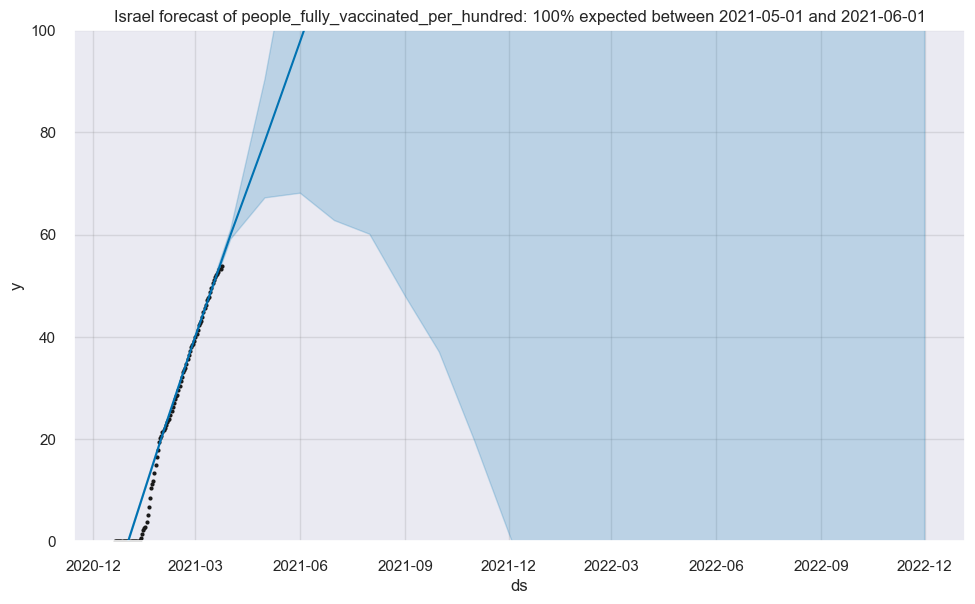

In [173]:
fcast('Israel')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds       yhat  yhat_lower  yhat_upper
0 2021-01-01   0.053369   -0.482245    0.558741
1 2021-02-01   1.556242    1.056469    2.050890
2 2021-03-01   7.299136    6.797183    7.851345
3 2021-04-01  16.069708   15.543923   16.588155
4 2021-05-01  24.311235   22.962464   25.628968
5 2021-06-01  32.746011   29.419151   35.858652
6 2021-07-01  40.956894   35.299886   46.403135
7 2021-08-01  49.484607   40.798465   57.903993
8 2021-09-01  57.882871   45.429770   69.282769
9 2021-10-01  66.141055   49.662647   80.848908


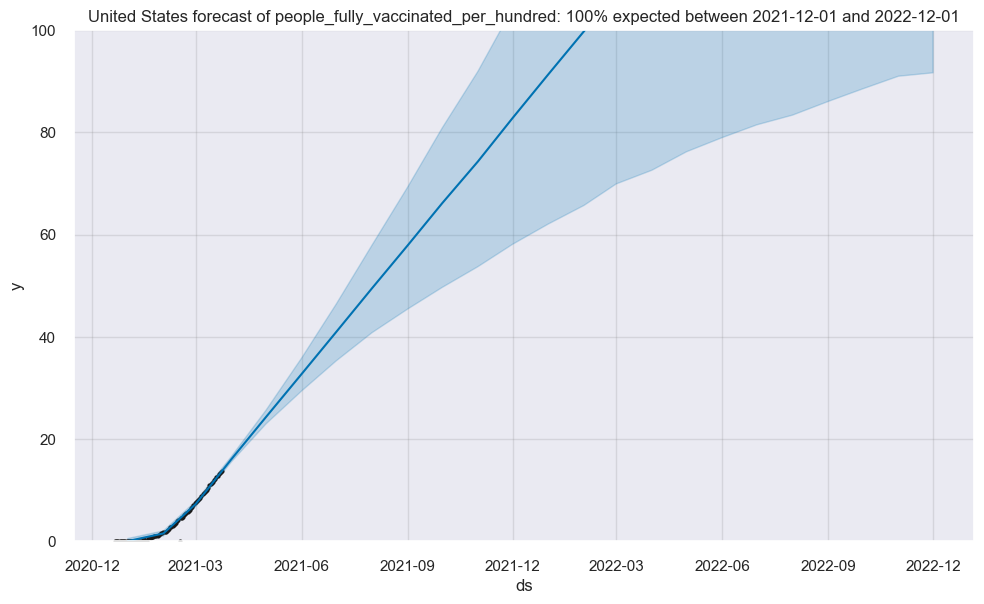

In [174]:
fcast('United States')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds       yhat  yhat_lower  yhat_upper
0 2021-01-01   0.018316    0.000317    0.035061
1 2021-02-01   0.783717    0.767477    0.799706
2 2021-03-01   2.612111    2.595808    2.629102
3 2021-04-01   4.821964    4.769898    4.879143
4 2021-05-01   6.991991    6.451333    7.544381
5 2021-06-01   9.217154    7.813464   10.520660
6 2021-07-01  11.404650    8.998786   13.644853
7 2021-08-01  13.624879   10.116474   16.955052
8 2021-09-01  15.881848   11.055942   20.351959
9 2021-10-01  18.068530   11.863089   23.868181


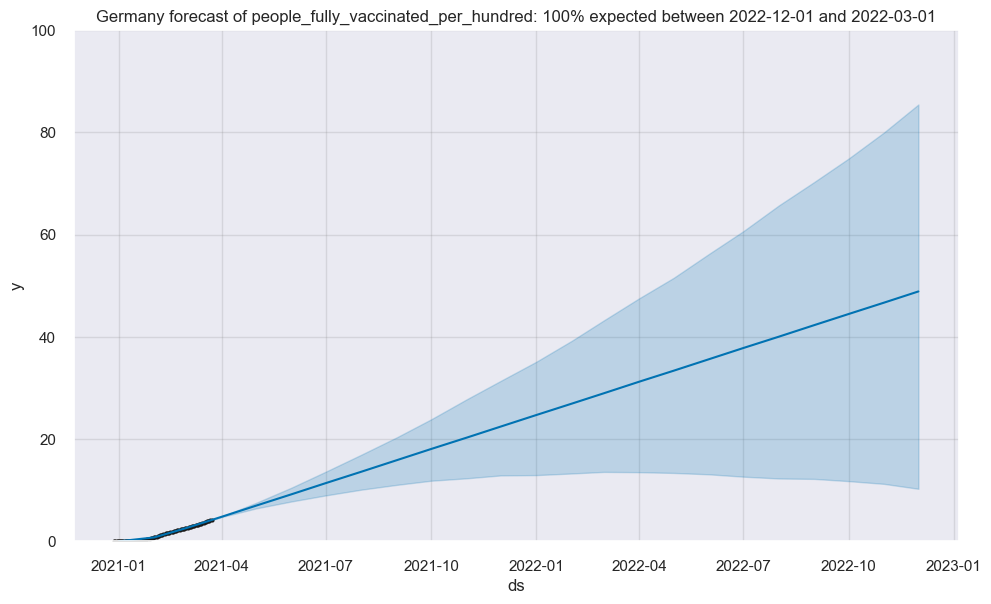

In [175]:
fcast('Germany')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds      yhat  yhat_lower  yhat_upper
0 2021-01-01  0.003490   -0.002450    0.009652
1 2021-02-01 -0.001041   -0.007221    0.004469
2 2021-03-01  0.189328    0.183239    0.196150
3 2021-04-01  0.764534    0.752140    0.775809
4 2021-05-01  1.360710    1.241460    1.469270
5 2021-06-01  1.968219    1.677697    2.254026
6 2021-07-01  2.557584    2.053093    3.032479
7 2021-08-01  3.166661    2.410047    3.897667
8 2021-09-01  3.778267    2.756768    4.765727
9 2021-10-01  4.375075    3.002667    5.676799


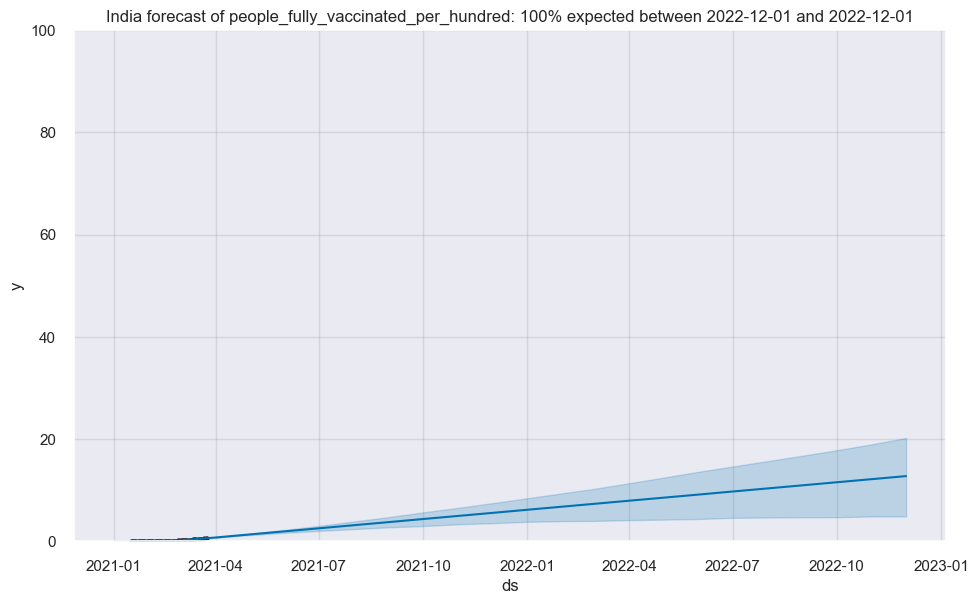

In [176]:
fcast('India')

In [ ]:
df_time_m_us = df_time_m[df_time_m.country == 'United States']
df_time_m_us1 = df_time_m_us[['date','daily_vaccinations']]
#train - test - split
df_time_m_us2 = df_time_m_us1
train_test_split_ratio = int(len(df_time_m_us2)*0.8)
train_data, test_data = df_time_m_us2[:train_test_split_ratio], df_time_m_us2[train_test_split_ratio:]



In [ ]:
# prepare expected column names
train_data.columns = ['ds', 'y']
train_data['ds']= pd.to_datetime(train_data['ds'])
# define the model
model = Prophet()
# fit the model
model.fit(train_data)

Make an In-Sample Forecast

forecast on historical data.

That is, we can make a forecast on data used as input to train the model. Ideally, the model has seen the data before and would make a perfect prediction.

Nevertheless, this is not the case as the model tries to generalize across all cases in the data.

This is called making an in-sample (in training set sample) forecast and reviewing the results can give insight into how good the model is. That is, how well it learned the training data.

A forecast is made by calling the predict() function and passing a DataFrame that contains one column named ‘ds‘ and rows with date-times for all the intervals to be predicted.

There are many ways to create this “forecast” DataFrame. In this case, we will loop over the month december 2020 to end of February 2021.

In [ ]:
# define the period for which we want a prediction
future = list()
for i in range(1, 29):
    date = '2021-02-%02d' % i
    future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])

# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
pyplot.show()

The training data are represented as black dots and the forecast is a blue line with upper and lower bounds in a blue shaded area.

We can see that the forecasted days are not a good match for the real observations. It is better when the bounds are taken into account but the last decrease in daily vaccinations was not met.

## Make an Out-of-Sample Forecast

 model to make a prediction beyond the training data.


In [ ]:
future = list()
for i in range(1, 30):
    date = '2021-03-%02d' % i
    future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(50))
# plot forecast
model.plot(forecast)
pyplot.show()

Manually Evaluate Forecast Model

In [ ]:
df_time_m_us2 = df_time_m_us1
train_test_split_ratio = int(len(df_time_m_us2)*0.8)
train_data, test_data = df_time_m_us2[:train_test_split_ratio], df_time_m_us2[train_test_split_ratio:]
# prepare expected column names
train_data.columns = ['ds', 'y']
train_data['ds']= pd.to_datetime(train_data['ds'])
test_data.columns = ['ds', 'y']
test_data['ds']= pd.to_datetime(test_data['ds'])

In [ ]:
test_data['y'] = test_data['y'].astype(int)
train_data['y'] = train_data['y'].astype(int)

In [ ]:
future = list()
for i in range(1, 30):
    date = '2021-03-%02d' % i
    future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(50))
# plot forecast
model.plot(forecast)
pyplot.show()

In [ ]:
# create test dataset, remove last months
train = train_data.drop(train_data.index[-12:])
print(train.tail())
print(train_data.head())

In [ ]:
# calculate MAE between expected and predicted values for december
y_true = test_data['y'].values[-29:]#y_true = train_data['y'].values#[-1:]
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

In [ ]:
y_true.shape

In [ ]:
y_pred.shape

In [ ]:
# plot expected vs actual
pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()

In [ ]:
test_timestamps = []
for i in range (10):
    test_timestamps.append(pd.to_datetime(df_time_m.index[-1]) - (i+1)*pd.Timedelta(hours=24))
test_timestamps.sort()

val_timestamps = [pd.to_datetime("2020-12-13")]
for i in range (9):
    val_timestamps.append(pd.to_datetime(val_timestamps[0]) + (i+1)*pd.Timedelta(hours=24))
val_timestamps.sort()

Error Metrics Function (RMSE, R2, MAE, MAPE)

In [ ]:
def error_metrics(y_pred, y_truth, model_name = "default"):
    """
    Calculate error metrics for a single comparison between predicted and observed values
    """
    # calculating error metrics
    RMSE_return = np.sqrt(mean_squared_error(y_truth, y_pred))
    R2_return = r2_score(y_truth, y_pred)
    MAE_return = mean_absolute_error(y_truth, y_pred)
    MAPE_return = (np.mean(np.abs((y_truth - y_pred) / y_truth)) * 100)
    
    # saving error metrics in a dataframe and returning it
    name_error = ['RMSE', 'R2', 'MAE', 'MAPE']
    value_error = [RMSE_return, R2_return, MAE_return, MAPE_return/100]
    dict_error = dict()
    for i in range(len(name_error)):
        dict_error[name_error[i]] = [value_error[i]]
    errors = pd.DataFrame(dict_error).T
    errors.rename(columns={0 : model_name}, inplace = True)
    
    path = './data/error_metrics_{}.pkl'.format(model_name)
    errors.to_pickle(path)
        
    return(errors)

FB Prophet Prediction (hier auch noch mehr zu FB Prophet schreiben)

In [ ]:
def stan_init(m):
    """Retrieve parameters from a trained model.
    
    Retrieve parameters from a trained model in the format
    used to initialize a new Stan model.
    
    Parameters
    ----------
    m: A trained model of the Prophet class.
    
    Returns
    -------
    A Dictionary containing retrieved parameters of m.
    
    """
    res = {}
    for pname in ['k', 'm', 'sigma_obs']:
        res[pname] = m.params[pname][0][0]
    for pname in ['delta', 'beta']:
        res[pname] = m.params[pname][0]
    return res

In [ ]:
def rolling_prophet_model(data, tfstart, prediction_window_size_hrs = 24, train_window_size_days = 90,
                          timesteps = 18, lags = 1, logtransformation = True, target_name = "target_losses_norm"):
    """
        Predict values with a Prophet Model for a chosen timespan with a rolling-forward training window of a
        chosen size (differenced time series will be predicted).
        - data: input dataframe
        - tfstart: start timestamp of the timespan to predict for
        - prediction_window_size_hrs: size of the prediction window in hours
        - train_window_size_days: size of the training window in days
        - timesteps: number of timesteps that will be predicted ahead on each step 
        - lags: number of lags of the target_variable that should be included in the dataframe
        - logtransformation: should the target variable be transformed with the log-function for the prediction
        - target_name: column name of the target variable
        
    """
    #creating a working data frame to not change the actual input dataframe
    workframe = data.copy(deep = True)
    
    #if logtransformation is wanted
    if logtransformation == True:
        workframe[target_name] = np.log(workframe[target_name])
    
    #if lags should be included, they will be generated
    for i in range(lags):
        workframe[f"lag{i+1}"] = workframe[target_name].shift(i+1)
        
    #nan values after creation of lags will be dropped
    workframe.dropna(inplace = True)

    #creating another copy to keep the undifferenced values for backtransformation
    workframe_real = workframe.copy(deep = True)
    
    #calculating the differenced values for the target column
    workframe[target_name] = workframe[target_name].diff(1)
    
    #calculating the differenced values for the included lags
    if lags >= 1:
        for i in range(lags):
            workframe[f"lag{i+1}"] = workframe[f"lag{i+1}"].diff(1)
            
    #nan values after creation of lags will be dropped
    workframe.dropna(inplace = True)
        
    #setting start point of initial training window dependent on training window size
    train_start = pd.to_datetime(tfstart) - pd.Timedelta(days = train_window_size_days)
    
    #setting end point of test set dependent on chosen prediction window size
    tfend = pd.to_datetime(tfstart) + pd.Timedelta(hours = prediction_window_size_hrs)
    
    #making working dataframe compatible with fbprophet
    workframe.rename(columns={target_name: "y"}, inplace = True)
    
    #splitting data in train and test
    df_test = workframe[(workframe.index >= tfstart) & (workframe.index <= tfend)]    
    df_train = workframe[(workframe.index >= train_start) & (workframe.index < tfstart)]
    
    #making the copy with the undifferenced target values compatible with prophet
    workframe_real.rename(columns={target_name: "y"}, inplace = True)
    
    #creating copy of the undifferenced test data for later evalutation against predictions    
    y_test = list()
    for i in range(timesteps):
        y_test.append(workframe_real[(workframe_real.index > tfstart) & (workframe_real.index < tfend)]["y"].shift(-i).iloc[:-timesteps])
  
    #saving all the additional regressors (not the target) in list
    regressors = list(df_train.columns)
    regressors.remove("y")
    
    #adding datestamps to dataframes for compatibility with fbprophet
    df_test["ds"] = df_test.index
    df_train["ds"] = df_train.index
    
    # setting up a list to store the prediction results in
    predictions = list()

    #iterating over the test set
    for t in tqdm(range(len(df_test)-timesteps)):
            
            #initializing new Prophet model
            model = Prophet(yearly_seasonality = False)
            
            #adding all the regressors with the same hyperparameters
            for name in list(regressors):
                model.add_regressor(name, prior_scale = 1, standardize = True, mode='multiplicative')            
            
            #training the model on the current training dataframe with the saved initial parameters from the last model, if there was one
            try:
                model.fit(df_train, init = parameters);
            except NameError:
                model.fit(df_train);
            
            #saving the parameters of the fitted model for warm-start training of the next model
            parameters = stan_init(model)
            
            #the timestamp before the current prediciton timestep is calculated
            index_before = df_test.index[0] - pd.Timedelta(minutes = 10)

            #setting up future dataframe (two steps ahead) with all regressors filled in assumption of perfect forecast for regressors
            future = df_test.drop(columns = ["y"]).iloc[0:timesteps] #.to_frame().T
            
            #predicting next timestep
            forecast = model.predict(future)
            
            predictions_inner_list = list()
            
            # setting the physically possible boundaries of the predictions (must be between 0 and 1 after backtransformation) depending on the chosen transformations
            for i in range(timesteps):
                if (logtransformation == True):
                    if forecast["yhat"].iloc[0:i].sum() + workframe_real.loc[index_before]["y"] < -30:
                         predictions_inner_list.append(-30)
                    elif forecast["yhat"].iloc[0:i].sum() + workframe_real.loc[index_before]["y"] >= 0:
                         predictions_inner_list.append(0)
                    else:
                         predictions_inner_list.append(forecast["yhat"].iloc[0:i].sum() + workframe_real.loc[index_before]["y"])
                            
                else:
                    if forecast["yhat"].iloc[0:i].sum() + workframe_real.loc[index_before]["y"] < 0:
                        predictions_inner_list.append(0)
                    elif forecast["yhat"].iloc[0:i].sum() + workframe_real.loc[index_before]["y"] >= 1:
                        predictions_inner_list.append(1)
                    else:
                        predictions_inner_list.append(forecast["yhat"].iloc[0:i].sum() + workframe_real.loc[index_before]["y"])
                    
            predictions.append(predictions_inner_list)
                                         
            #dropping the left end point of the training dataframe            
            df_train.drop(df_train.index[0], inplace = True)
            
            #appending the left end point of the test dataframe to the training dataframe
            df_train = df_train.append(df_test.iloc[0].to_frame().T)
            
            #dropping the left end point of the test dataframe
            df_test.drop(df_test.index[0], inplace = True)
            
    columnnames = list()
    testcolumnnames = list()
    
    for i in range(timesteps):
        columnnames.append(f"y_pred{i+1}")
        testcolumnnames.append(f"y_test{i+1}")

    results = pd.DataFrame(columns = columnnames)
    original = pd.DataFrame(columns = testcolumnnames)
    
    for i in range(timesteps):
        results[f"y_pred{i+1}"] = pd.Series(v for v in [el[i] for el in predictions])
        original[f"y_test{i+1}"] = y_test[i]
        

    #setting the indices as they were 
    results.index = y_test[0].index
    
    #backtransformation to real values if logtransformation was used
    if logtransformation == True:
        results = np.exp(results)
        original = np.exp(original)
         
    ##creating the dataframe that will be saved as a file
    #results.to_csv(f".data/{filename}_predictions.csv")
    #original.to_csv(f".data/{filename}_test.csv")
    #print(f"Predictions and test values saved.")
    
    #returning the dataframes with the results
    return results, original

Tuning Prophet Model on Validation Data

In [ ]:
y_pred, y_test = rolling_prophet_model(data = df_time_m, tfstart = val_timestamps[0], prediction_window_size_hrs = 240, train_window_size_days = 60, timesteps = 18, lags = 2, logtransformation = True, target_name = "people_fully_vaccinated_per_hundred")

In [ ]:
columnnames = list()
for i in range(18):
    columnnames.append(f"FB Prophet Prediction Step {i+1}")
    
val_errors = pd.DataFrame(columns = columnnames)

for i in range(18):
    val_errors[f"FB Prophet Prediction Step {i+1}"]  = error_metrics(y_pred[f"y_pred{i+1}"],y_test[f"y_test{i+1}"])["default"]
    
val_errors = val_errors.T

## Parallelizing Cross Validation with Dask

In [241]:
from distributed import Client
from fbprophet.diagnostics import cross_validation

client = Client()
client

<Client: 'tcp://127.0.0.1:55447' processes=4 threads=8, memory=8.00 GiB>

In [242]:
%%time
df_cv = cross_validation(model, 
                         horizon="365 days",
                         period="182.5 days", 
                         initial="730 days", 
                         parallel="dask"
                        )

ValueError: Less data than horizon.

## Updated dataset until

## Conclusion